In [1]:
# %pip install numpy
# %pip install easyocr
# %pip install imutils
# %pip install scipy

In [2]:
import cv2
import numpy as np
import imutils
import easyocr
import scipy.ndimage  as ni
import matplotlib.pyplot as plt

<p>loading image</p>

In [3]:
img_src = './Statics/number_2.png'

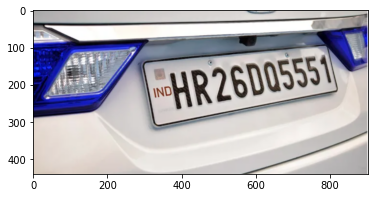

In [4]:
plt.imshow(cv2.imread(img_src))

Using Easyocr for unformatted image

In [5]:
reader = easyocr.Reader(['en'])
result = reader.readtext(img_src)
result

[([[303.98534204320856, 158.54723135555088],
   [813.1200910623421, 100.9380805625566],
   [817.0146579567914, 223.45276864444912],
   [307.8799089376579, 282.0619194374434]],
  'lHR26DO5551]',
  0.17475100699541432)]

In [6]:
text = result[0][1]
text

'lHR26DO5551]'

#### Read in Image, Grayscale and Blur

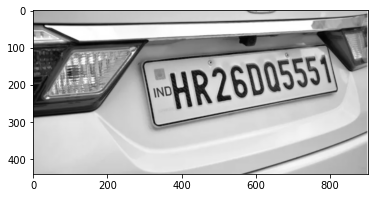

In [7]:
img = cv2.imread(img_src)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

#### Apply filter and find edges for localization

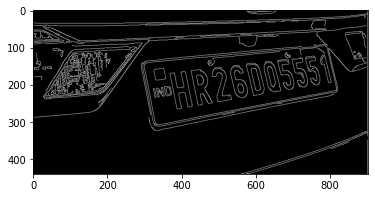

In [8]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

#### Find Contours and Apply Mask

In [9]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [10]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break
location

array([[[792, 101]],

       [[303, 142]],

       [[329, 303]],

       [[816, 215]]], dtype=int32)

In [11]:
mask = np.zeros(gray.shape, np.uint8)

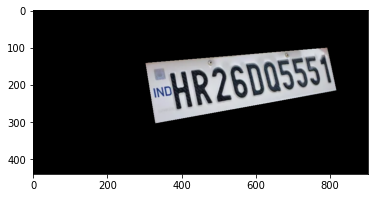

In [12]:
masked_image = cv2.drawContours(mask, [location], 0,255, -1)
masked_image = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

#### Cropping image to remove skewness

In [13]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
cropped_image


array([[132, 132, 132, ...,  32,  36,  40],
       [134, 135, 135, ...,  28,  31,  36],
       [135, 136, 136, ...,  26,  28,  32],
       ...,
       [197, 196, 195, ..., 232, 232, 232],
       [198, 196, 195, ..., 232, 232, 232],
       [198, 196, 195, ..., 231, 231, 231]], dtype=uint8)

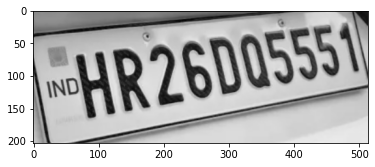

In [14]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

### Fixing Skewness


In [15]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = ni.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        hist, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, 
              borderMode=cv2.BORDER_REPLICATE)
    return best_angle, rotated

-4


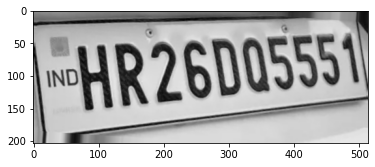

In [16]:
image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
angle, rotated = correct_skew(image)
print(angle)
plt.imshow(rotated)

#### Using Easy OCR To Read Text

In [17]:
reader = easyocr.Reader(['en'], gpu=True)
result = reader.readtext(rotated)
result

[([[15, 83], [79, 83], [79, 123], [15, 123]], 'IND', 0.9998929770908314),
 ([[52, 10], [514, 10], [514, 170], [52, 170]],
  'HR26D05551',
  0.2998393201121727)]

In [18]:
for detection in result: 
    text = detection[1]
    print(text)

IND
HR26D05551
